In [25]:
import cv2
import matplotlib.pyplot as plt

In [26]:
# Define the GStreamer pipeline
gst_pipeline = (
    "udpsrc port=5600 caps=application/x-rtp ! "
    "rtph264depay ! "
    "h264parse ! "
    "avdec_h264 ! "
    "videoconvert ! "
    "appsink"
)

In [27]:
# Open the video stream
cap = cv2.VideoCapture(gst_pipeline, cv2.CAP_GSTREAMER)


(python:190138): GStreamer-CRITICAL **: 16:24:39.282: gst_caps_get_structure: assertion 'GST_IS_CAPS (caps)' failed

(python:190138): GStreamer-CRITICAL **: 16:24:39.282: gst_structure_get_int: assertion 'structure != NULL' failed
[ WARN:0@3537.366] global cap_gstreamer.cpp:1714 open OpenCV | GStreamer warning: cannot query video width/height

(python:190138): GStreamer-CRITICAL **: 16:24:39.282: gst_structure_get_fraction: assertion 'structure != NULL' failed
[ WARN:0@3537.366] global cap_gstreamer.cpp:1722 open OpenCV | GStreamer warning: cannot query video fps
[ WARN:0@3537.366] global cap_gstreamer.cpp:1777 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


In [28]:
if not cap.isOpened():
    print("Failed to open video stream.")
    exit()

In [29]:
cap.isOpened()

True

In [ ]:
cap.release()

In [30]:
cap.isOpened()

True

In [ ]:
ret, frame = cap.read()
plt.imshow(frame)

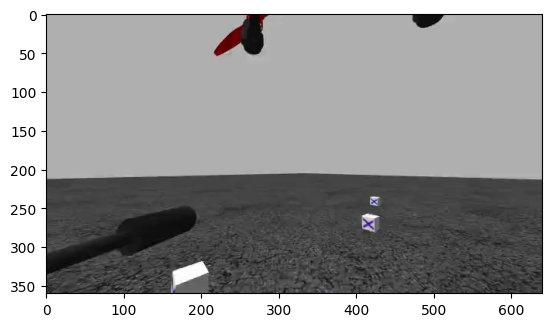

In [155]:
plt.imshow(frame)

# Check overlap with the pattern

In [14]:
import numpy as np

def calculate_pattern_significance(frame, pattern_image):
    """
    Calculate the significance of a pattern in a given video frame.
    
    :param frame: The current frame from the video feed (numpy array).
    :param pattern_image_path: The file path of the pattern image.
    :return: Significance score (float, 0 to 1).
    """
    # Load the pattern image
    # pattern_image = cv2.imread(pattern_image_path)

    # Check if pattern image is available
    if pattern_image is None:
        print("Pattern image not available. Returning a score of 0.")
        return 0.0

    # Resize the pattern if it is larger than the frame
    frame_height, frame_width = frame.shape[:2]
    pattern_height, pattern_width = pattern_image.shape[:2]

    if pattern_height > frame_height or pattern_width > frame_width:
        scale_factor = min(frame_height / pattern_height, frame_width / pattern_width)
        pattern_image = cv2.resize(pattern_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Convert frame and pattern to grayscale for template matching
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    pattern_gray = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result = cv2.matchTemplate(frame_gray, pattern_gray, cv2.TM_CCOEFF_NORMED)

    # Get the matching result threshold
    threshold = 0.8  # Adjust as needed
    match_locations = np.where(result >= threshold)

    # Calculate the coverage area
    match_count = len(match_locations[0])
    pattern_area = pattern_image.shape[0] * pattern_image.shape[1]
    frame_area = frame.shape[0] * frame.shape[1]

    if match_count > 0:
        total_pattern_area = match_count * pattern_area
        coverage_percentage = total_pattern_area / frame_area
        significance_score = min(coverage_percentage, 1.0)  # Cap at 1.0
    else:
        significance_score = 0.0

    return significance_score

In [15]:
pattern_image = cv2.imread("./oie_B0ZBfbt6lTfj.png")

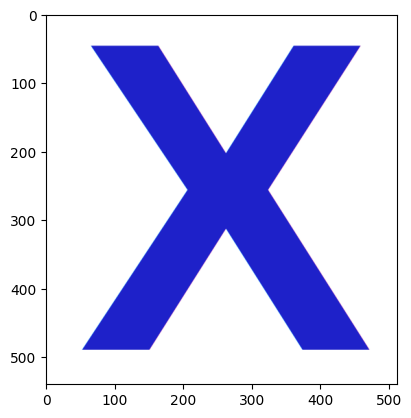

In [16]:
plt.imshow(pattern_image)

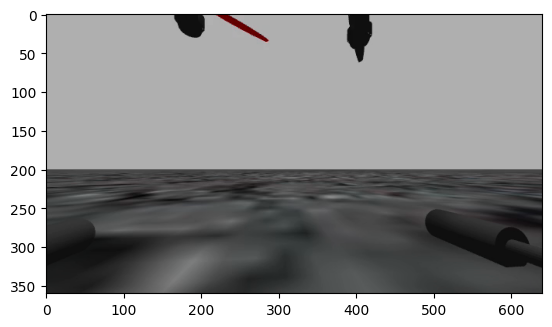

In [17]:
plt.imshow(frame)

In [254]:
calculate_pattern_significance(pattern_image, frame)

0.0

In [43]:
# !mkdir /home/sabari/.gazebo/models/custom_box/materials/textures

In [18]:
import cv2
import numpy as np

class PatternDetector:
    def __init__(self, pattern_image):
        """
        Initialize the pattern detector with a template image
        """
        self.pattern = pattern_image
        self.pattern_gray = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2GRAY)
        # Create SIFT detector
        self.sift = cv2.SIFT_create()
        # Compute pattern keypoints and descriptors once
        self.pattern_kp, self.pattern_des = self.sift.detectAndCompute(self.pattern_gray, None)
        
    def detect_blue_regions(self, frame):
        """
        Detect blue regions in the frame
        """
        # Convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Define blue color range (adjust these values based on your specific blue)
        lower_blue = np.array([100, 50, 50])
        upper_blue = np.array([130, 255, 255])
        
        # Create mask for blue color
        blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
        # Apply morphological operations to clean up the mask
        kernel = np.ones((3,3), np.uint8)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
        
        return blue_mask

    def find_feature_matches(self, frame_gray):
        """
        Find feature matches between pattern and frame
        """
        # Detect keypoints and compute descriptors
        frame_kp, frame_des = self.sift.detectAndCompute(frame_gray, None)
        
        if frame_des is None or len(frame_des) < 2:
            return []
            
        # Create BF Matcher
        bf = cv2.BFMatcher()
        
        # Find matches
        try:
            matches = bf.knnMatch(self.pattern_des, frame_des, k=2)
        except:
            return []
            
        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
                
        return good_matches

    def multi_scale_template_matching(self, frame_gray):
        """
        Perform multi-scale template matching
        """
        template_matches = []
        
        # Make sure pattern is smaller than frame
        frame_height, frame_width = frame_gray.shape
        pattern_height, pattern_width = self.pattern_gray.shape
        
        # Calculate initial scale if pattern is larger than frame
        if pattern_height > frame_height or pattern_width > frame_width:
            scale_height = frame_height / pattern_height * 0.9  # 90% of frame height
            scale_width = frame_width / pattern_width * 0.9    # 90% of frame width
            initial_scale = min(scale_height, scale_width)
        else:
            initial_scale = 1.0
        
        # Define scale range - start from initial_scale and go smaller
        scales = np.linspace(initial_scale, 0.1, 20)
        
        for scale in scales:
            # Resize pattern
            width = int(self.pattern_gray.shape[1] * scale)
            height = int(self.pattern_gray.shape[0] * scale)
            
            if width < 10 or height < 10:  # Skip if too small
                continue
            if width >= frame_width or height >= frame_height:  # Skip if too large
                continue
                
            resized_pattern = cv2.resize(self.pattern_gray, (width, height))
            
            # Template matching
            try:
                result = cv2.matchTemplate(frame_gray, resized_pattern, cv2.TM_CCOEFF_NORMED)
                
                # Get matches above threshold
                threshold = 0.6
                locations = np.where(result >= threshold)
                
                for pt in zip(*locations[::-1]):
                    template_matches.append({
                        'position': pt,
                        'size': (width, height),
                        'score': result[pt[1], pt[0]]
                    })
            except cv2.error:
                continue  # Skip if there's an error with this scale
                    
        return template_matches
        
    def detect_pattern(self, frame):
        """
        Main detection method combining multiple approaches
        """
        # Convert frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # 1. Detect blue regions
        blue_mask = self.detect_blue_regions(frame)
        
        # 2. Find feature matches
        feature_matches = self.find_feature_matches(frame_gray)
        
        # 3. Perform multi-scale template matching
        template_matches = self.multi_scale_template_matching(frame_gray)
        
        # Calculate confidence score based on all methods
        confidence = self.calculate_confidence(blue_mask, feature_matches, template_matches, frame)
        
        return confidence, blue_mask, len(feature_matches), len(template_matches)
    
    def calculate_confidence(self, blue_mask, feature_matches, template_matches, frame):
        """
        Calculate overall confidence score
        """
        # Blue region score
        blue_pixels = np.sum(blue_mask > 0)
        blue_score = min(1.0, blue_pixels / (frame.shape[0] * frame.shape[1] * 0.1))
        
        # Feature matching score
        feature_score = min(1.0, len(feature_matches) / 20.0)
        
        # Template matching score
        template_score = min(1.0, len(template_matches) / 5.0)
        
        # Weighted combination
        weights = [0.4, 0.3, 0.3]  # Blue detection, feature matching, template matching
        final_score = (
            weights[0] * blue_score +
            weights[1] * feature_score +
            weights[2] * template_score
        )
        
        return final_score

In [19]:
detector = PatternDetector(pattern_image)

In [20]:
confidence, blue_mask, num_features, num_templates = detector.detect_pattern(frame)

In [23]:
confidence

0.054913194444444445

In [24]:
cap.release()

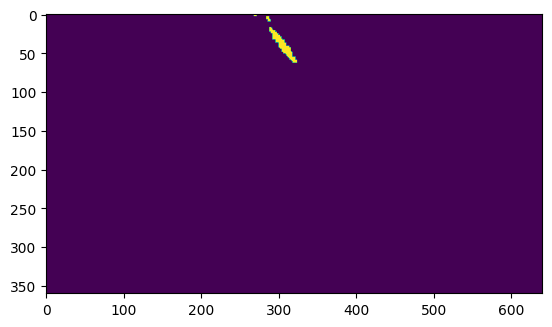

In [269]:
plt.imshow(blue_mask)